In [8]:
import numpy as np
import pandas as pd

frame = pd.read_excel("data_gdm_discrete_BMI_merged.xlsx", engine="openpyxl")
frame.oDM = (frame.oDM == 2).astype(int)
for name in frame.columns:
    frame[name] = frame[name].astype('category')

print (frame)
print (frame.oDM.value_counts())

     AgeCat BMICat Race Education GravCat SmokeCat1 SmokeCat2 oDM
0         3      0    1         3       2         1         1   0
1         1      2    2         2       1         1         2   0
2         0      0    2         1       1         2         2   0
3         2      2    3         3       2         2         2   0
4         1      0    3         4       1         2         2   0
...     ...    ...  ...       ...     ...       ...       ...  ..
9215      2      1    1         4       2         1         1   0
9216      1      0    3         3       2         2         2   0
9217      0      0    3         1       2         2         2   0
9218      2      1    1         2       3         1         1   0
9219      3      2    1         5       1         1         1   0

[9220 rows x 8 columns]
0    8832
1     388
Name: oDM, dtype: int64


In [9]:
counts = frame[frame.oDM == 1].AgeCat.value_counts()
counts = dict(zip(counts.index, counts.values))

slices = []
for age, count in counts.items():
    condition = (frame.oDM == 0) & (frame.AgeCat == age)
    data_slice = frame[condition].head(count)
    slices.append(data_slice)
slices.append(frame[frame.oDM == 1])
frame = pd.concat(slices)

In [10]:
print (frame[frame.oDM == 0].AgeCat.value_counts())
print (frame[frame.oDM == 1].AgeCat.value_counts())

4    144
2     85
3     76
1     57
0     26
Name: AgeCat, dtype: int64
4    144
2     85
3     76
1     57
0     26
Name: AgeCat, dtype: int64


In [11]:
from sklearn.model_selection import StratifiedKFold
from spn.algorithms.LearningWrappers import learn_parametric
from spn.structure.leaves.parametric.Parametric import Categorical, Gaussian
from spn.structure.Base import Context
import warnings 

train_data = frame.to_numpy()
names = frame.columns.tolist()
categories = ['Race', 'oDM']
ptypes = [Categorical if n in categories else Gaussian for n in names]
categorical = [n in categories for n in names]

In [12]:
from spn.algorithms.Inference import log_likelihood

for n in [20, 40, 60, 80, 100]:
    splitter = StratifiedKFold()
    ll = []
    for train_i, test_i in splitter.split(train_data, train_data[:, -1]):
        train = train_data[train_i]
        test = train_data[test_i]
        
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            context = Context(parametric_types = ptypes).add_domains(train)
            net = learn_parametric(train,
                                   ds_context = context,
                                   min_instances_slice = n)
            l = log_likelihood(net, test)
            ll.append(-np.sum(l))

    print ("%6d %8.4f ± %8.4f" % (n, np.mean(ll), np.std(ll)))

    20 -5056.4189 ± 1096.9721
    40 -4902.8340 ± 1248.1408
    60 -4444.6479 ± 1315.6911
    80 -4328.0266 ± 1355.7380
   100 -4188.7904 ± 1409.9937


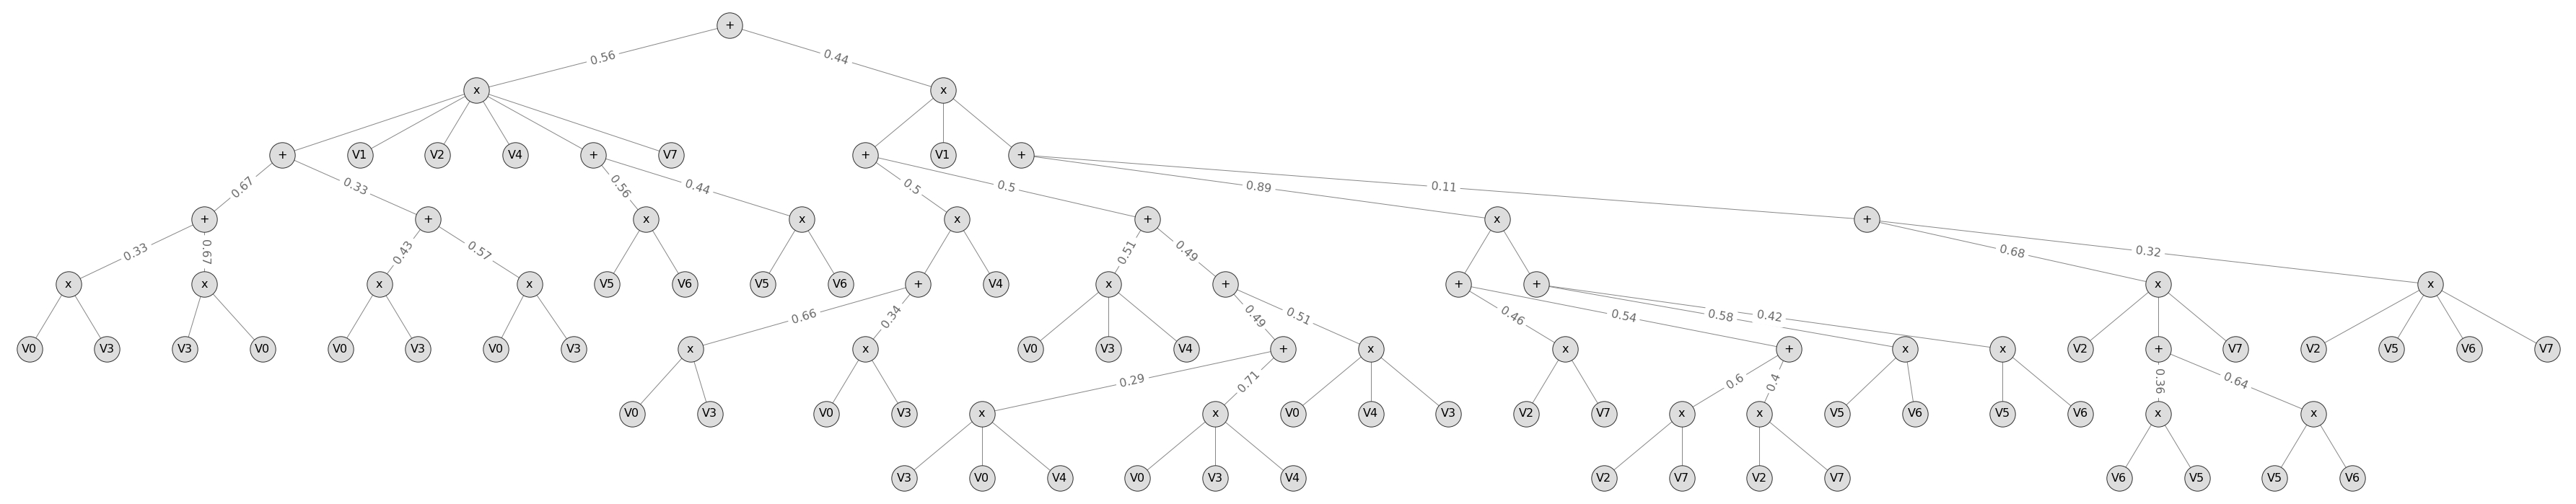

In [22]:
from spn.io.Graphics import plot_spn
import matplotlib.pyplot as plt
%matplotlib inline

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    context = Context(parametric_types=ptypes).add_domains(train_data)
    net = learn_parametric(train_data, 
                           ds_context = context, 
                           min_instances_slice = 20, ohe = True)

plt.figure(figsize = (50, 10))
plot_spn(net)

In [23]:
from csi import annotate, context_specific_independences

annotate(net, names, categorical, min_impurity_decrease=0.1)
for rule in context_specific_independences(net):
    print (rule)

([['Education > 4.5']], [['AgeCat', 'Education'], ['BMICat'], ['Race'], ['GravCat'], ['SmokeCat1', 'SmokeCat2'], ['oDM']], 0.9282407407407407)
([['Education <= 4.5']], [['AgeCat', 'Education', 'GravCat'], ['BMICat'], ['Race', 'SmokeCat1', 'SmokeCat2', 'oDM']], 1.0)
([['Education > 4.5'], ['SmokeCat1 > 1.5']], [['SmokeCat1'], ['SmokeCat2']], 0.9282407407407407)
([['Education > 4.5'], ['SmokeCat1 <= 1.5']], [['SmokeCat1'], ['SmokeCat2']], 0.9282407407407407)
([['Education <= 4.5'], ['AgeCat <= 1.5']], [['AgeCat', 'Education'], ['GravCat']], 0.8888888888888888)
([['Education <= 4.5'], ['Race != 8 and Race != 5']], [['Race', 'oDM'], ['SmokeCat1', 'SmokeCat2']], 1.0)
([['Education > 4.5'], ['AgeCat > 3.5'], ['Education <= 5.5']], [['AgeCat'], ['Education']], 0.7489942528735631)
([['Education > 4.5'], ['AgeCat > 3.5'], ['Education > 5.5']], [['Education'], ['AgeCat']], 0.7489942528735631)
([['Education > 4.5'], ['AgeCat <= 3.5'], ['AgeCat > 2.5']], [['AgeCat'], ['Education']], 0.913023679417

In [25]:
frame[frame.Education.astype(int) <= 4.5].oDM.value_counts()

0    202
1    199
Name: oDM, dtype: int64